In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [3]:
ls

'cw1_template 2022(1).ipynb'    Simpsons2022/      Task1test.ipynb
 development-examples.txt.txt   Simpsons2022.zip   Task2.ipynb
 product_reviews/               Task1.ipynb


In [4]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from operator import pos
from sys import ps1
from ast import Continue
import os 
import re
import copy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, wordnet, words
nltk.download('words')
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def preprocess(document: str):
  raw = document.read()

  # get all the lines
  raw = [line for line in raw.lower().split("\n") if line !=""]
  
  pos_reviews = []
  neg_reviews =[]
  pos_review_1 = []
  neg_review_1 = []
  review = []
  presimbol = None
  rating = 0
  t_occ = 0 
  #divide the cas with t tag or not True if t tag exist
  if '[t]' == raw[0]:
    t_exist = True 
  else:
    t_exist = False
  
  #Depends on t tag
  #consider reviews depend on rating 
  #put review in positive or negative
  for i in raw:
    if t_exist:
      if i == '[t]':
        if rating > 0:
          pos_reviews.append(review)
        if rating <0:
          neg_reviews.append(review)
          
        t_occ +=1
        rating =0
        review = []
      else:  
        if "##" in i:
          i = i.split("##")
          review.append(i[1])
          if "+" in i[0]:
            if '[+1]' in i[0]:
              rating +=1
            if '[+2]' in i[0]:
              rating +=2
            if '[+3]' in i[0]:
              rating +=3
            pos_review_1.append(i[1])
            presimbol = "+"
          elif "-" in i[0]:
            if '[-1]' in i[0]:
              rating -=1
            if '[-2]' in i[0]:
              rating -=1
            if '[-3]' in i[0]:
              rating -=1
            neg_review_1.append(i[1])
            presimbol = "-"
        else:
          if presimbol == None:
            continue
          elif presimbol == "+":
            pos_review_1.append(i[1])
          elif presimbol == "-":
            neg_review_1.append(i[1])
    else:
      if "##" in i:
        i = i.split("##")
        if "+" in i[0]:
          pos_reviews.append(i[1])
          presimbol = "+"
        elif "-" in i[0]:
          neg_reviews.append(i[1])
          presimbol = "-"
        else:
          if presimbol == None:
            continue
          elif presimbol == "+":
            pos_reviews.append(i[1])
          elif presimbol == "-":
            neg_reviews.append(i[1])
      else:
        continue

  if t_occ == 1:
    pos_reviews =  pos_review_1
    neg_reviews = neg_review_1

  #remove punctuation
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
  for sentence in pos_reviews:
    for items in sentence:
      items = BAD_SYMBOLS_RE.sub('', items)

  for sentence in neg_reviews:
    for items in sentence:
      items = BAD_SYMBOLS_RE.sub('', items)


  #remove stop words    
  stop_words = set(stopwords.words('english'))
  
  pos_tokens = []
  for review in pos_reviews:
    each_review = []
    for sentence in review:
      text = ' '.join(word for word in sentence.split() if word not in stop_words)
      each_review.append(text)
    pos_tokens.append(each_review)
  
  neg_tokens = []
  for review in neg_reviews:
    each_review = []
    for sentence in review:
      text = ' '.join(word for word in sentence.split() if word not in stop_words)
      each_review.append(text)
    neg_tokens.append(each_review)

  #put things in the dataframe with positive or negative label of sentiment
  dataframe = []
  for review  in pos_tokens:
    dataframe.append({"sentiment": "positive", "review": review})

  for review in neg_tokens:
    dataframe.append({"sentiment": "negative", "review": review})


  return dataframe



path = "product_reviews/product_reviews/"
filelist = os.listdir(path)

counters = []
num_doc = 0
wordvec = []
allwords = []

#each document preprocess and put in dataframe
dataframe = []
for x in filelist:
  if x.endswith(".txt"):
    document = open(path+x, "r")
    data = preprocess(document)
    dataframe.append(pd.DataFrame(data))

df = pd.concat(dataframe,ignore_index= True)
print(df)
    

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each review
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

#tokenize every review in the data frame
tokenizer = Tokenizer(
    num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True
)
tokenizer.fit_on_texts(df["review"].values)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

    sentiment                                             review
0    positive  [want start saying camera small reason., peopl...
1    positive  [ok, quite everything...but camera compact sid...
2    positive  [bought camera reason many considering it, alr...
3    positive  [researched digital cameras month purchasing s...
4    positive  [wonderfully small digital camera produces fan...
..        ...                                                ...
936  negative  [bought product reading editor's choice articl...
937  negative  [ain't computer geek, wrestle best them., prog...
938  negative  [begining think computer-retarded dealing prog...
939  negative  [originally bought mcafee virusscan 7 amazon.,...
940  negative  [modern pc lots speed memory, firewall brought...

[941 rows x 2 columns]
Found 3302 unique tokens.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [19]:
#make input sequence in the same length for modelling
X = tokenizer.texts_to_sequences(df["review"].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of data tensor:", X.shape)

Shape of data tensor: (941, 250)


In [20]:
#convertin label to numbers
Y = pd.get_dummies(df["sentiment"]).values
print("Shape of label tensor:", Y.shape)
print(Y)

Shape of label tensor: (941, 2)
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [21]:
# train and test data split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.10, random_state=42
)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(846, 250) (846, 2)
(95, 250) (95, 2)


In [37]:
# set the parameter for LSTM model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_14 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dense_14 (Dense)            (None, 2)                 202       
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
epochs = 50 #30 
batch_size = 32


#trainning model with training datas
history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)],
)

#evaluate the accuracy
accr = model.evaluate(X_test, Y_test)
print("Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}".format(accr[0], accr[1]))

Epoch 1/50
22/22 [==============================] - 10s 355ms/step - loss: 0.6201 - accuracy: 0.7120 - val_loss: 1.3183 - val_accuracy: 0.5132
Epoch 2/50
22/22 [==============================] - 8s 342ms/step - loss: 0.6022 - accuracy: 0.7194 - val_loss: 0.7955 - val_accuracy: 0.5132
Epoch 3/50
22/22 [==============================] - 7s 339ms/step - loss: 0.5754 - accuracy: 0.7194 - val_loss: 0.9550 - val_accuracy: 0.5132
Epoch 4/50
22/22 [==============================] - 8s 342ms/step - loss: 0.5645 - accuracy: 0.7194 - val_loss: 0.9292 - val_accuracy: 0.5132
Epoch 5/50
6/6 [==============================] - 0s 41ms/step - loss: 0.5675 - accuracy: 0.7340
Test set
  Loss: 0.568
  Accuracy: 0.734


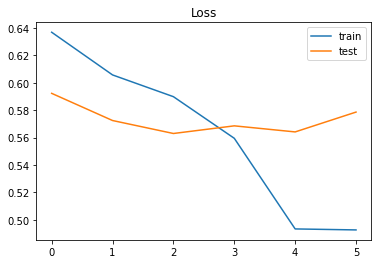

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

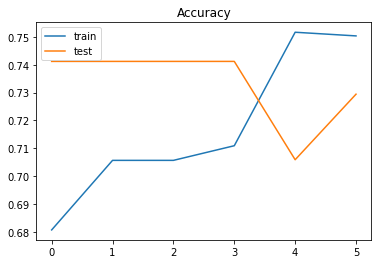

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [41]:
def network():
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(2, activation="softmax"))
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  # print(model.summary())
  return model

In [42]:
#5-fold cross validation 
kf = KFold(n_splits=5,shuffle = True)
loss = []
acc = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  Y_train, Y_test = Y[train_index], Y[test_index]

  epochs = 50
  batch_size = 32
  model = network()
  history = model.fit(
      X_train,
      Y_train,
      epochs=epochs,
      batch_size=batch_size,
      validation_split=0.1, 
      callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)],
  )

  accr = model.evaluate(X_test, Y_test)
  print("Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}".format(accr[0], accr[1]))
  loss.append(accr[0])
  acc.append(accr[1])

print("mean of accuracy:",np.mean(acc))
print("standard deviation of accuracy:",np.std(acc))

Epoch 1/50
22/22 [==============================] - 10s 355ms/step - loss: 0.6317 - accuracy: 0.7027 - val_loss: 0.7929 - val_accuracy: 0.5132
Epoch 2/50
22/22 [==============================] - 7s 341ms/step - loss: 0.5876 - accuracy: 0.7175 - val_loss: 1.0486 - val_accuracy: 0.5132
Epoch 3/50
22/22 [==============================] - 8s 344ms/step - loss: 0.5843 - accuracy: 0.7175 - val_loss: 0.9168 - val_accuracy: 0.5132
Epoch 4/50
6/6 [==============================] - 0s 43ms/step - loss: 0.5728 - accuracy: 0.7407
Test set
  Loss: 0.573
  Accuracy: 0.741
Epoch 1/50
22/22 [==============================] - 10s 350ms/step - loss: 0.6207 - accuracy: 0.7253 - val_loss: 0.9307 - val_accuracy: 0.5000
Epoch 2/50
22/22 [==============================] - 8s 341ms/step - loss: 0.5652 - accuracy: 0.7415 - val_loss: 1.1563 - val_accuracy: 0.5000
Epoch 3/50
22/22 [==============================] - 8s 343ms/step - loss: 0.5504 - accuracy: 0.7415 - val_loss: 1.1508 - val_accuracy: 0.5000
Epoch 4/